# Проект: Система поиска подходящих товаров на основе дообученной CLIP модели


## Постановка задачи

Нужно реализовать такую систему: пользователь описывает вещь словами, система находит и показывает наиболее близкие позиции из базы. Компания выходит на международный рынок, поэтому система будет работать на английском языке.

Нужно:
- дообучить модель CLIP на датасете товаров из магазинов одежды,
- реализовать систему поиска изображений товаров по текстовым запросам.

## Критерии успеха

- Целевые значения **среднего CLIP** score должны быть **выше 30**.
- Ожидаемый результат: реализована поисковая система, способная принимать текстовые запросы и возвращать наиболее релевантные изображения из датасета. Система должна работать эффективно, то есть не пересчитывать каждый раз векторные представления картинок.

<div class="alert alert-secondary" style="background-color:#D9EEE1;color:black;">

## Описание данных
[Ссылка](https://www.kaggle.com/datasets/nirmalsankalana/fashion-product-text-images-dataset) на датасет.

Датасет содержит картинки и таблицу `data.csv`.

В этой таблице такие поля: 
- `image` — название файла изображения в папке с изображениями.
- `description` — описание элемента одежды, изображённого на картинке.
- `display name` — название элемента на картинке.
- `category` — категория элемента одежды.

В проекте вам понадобятся только первые два столбца: `image` — для визуальных данных, `description` — для текстовых.

## Инициализация

In [1]:
# 👷🚧🚧🚧🚧🚧 просто для дебага без GPU - переключить при итоговом обучении и замере в False:
JUST_DEBUG_WO_GPU = True
DEBUG_MAX_ELEMENTS = 10

RANDON_STATE = 42

DATA_CSV_PATH = "archive/data.csv"
IMAGES_PATH = "archive/data/"


### Импорт библиотек

In [2]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import textwrap

# Этап 1. Fine-tuning CLIP

## Загрузка и исследовательский анализ данных


In [3]:
df = pd.read_csv(DATA_CSV_PATH).drop(columns=['display name', 'category'])

In [4]:
pd.options.display.max_colwidth = 1000

In [5]:
df.head()

,image,description
0,3238.jpg,"Round toed, black sports shoes with red accents, low top styling and central lace-ups Leather upper with stitched detail, overlay, Formstrip and Ducati branding on the sides and reinforced heel collar with branding Soft tongue and inner, branding on the tongue Cushioned footbed with branding at the heel Printed detail at the midsole Textured rubber outsole with patterned grooves and branding Warranty: 3 months against manufacturing defects only"
1,43044.jpg,"Style Note Built with the breathability and zero-distraction Fit that athletes demand, these boardshorts come in a body-friendly design. These high-performance shorts are great for a day out at the beach and are designed to aid your aquatic performance. Team them with T-shirts and flip flops. Product Details Charcoal grey boardshorts, with a velcro closure and a cord tie detail, zipped pocket and a nike swoosh on left leg Material and Care 100% polyester Machine wash separately in cold water using a mild detergent Do not bleach Tumble dry low Cool iron; do not iron on decorations Size and fit Regular fit"
2,54018.jpg,"Teal handbag that has stitch detailing with a pleated and panel design on the front One main zipped compartment that has an inner zipped pocket and an organiser sleeve One zipped pocket on the front One long, adjustable strap woven through metallic loops for carrying ease and style One zipped pocket at the back"
3,8141.jpg,"Perfectly stylish, this fastrack analog wrist watch is a great buy for those who enjoy performance and style. With excellent touches and comfort, this watch makes for an excellent daily wear. Case diameter : 30 mm Case thickness : 5 mm Dial shape : Square Plastic case with a fixed bezel for added durability, style and comfort Leather strap with stitch detailing, brand name printed on the inner part and a tang clasp Silver dial in a radiating pattern with minute marking in pink from 6 o& rsquo clock to 12 o& rsquo clock position, brand name at 3 o& rsquo clock position and brand logo at 12 o& rsquo clock position Quartz movement of time display with carved out hour and minute hands Screw to reset time Solid case back made of stainless steel for enhanced durability Water resistance at 30 meters, allowing you to use it even when swimming"
4,22245.jpg,"These id mid-top chukka shoes add a fresh spin on a classic style with its wide midsole. The humble sneaker reached a new high with this casual shoe, with its contrasting textures and subtle colour map. Wear this with a crisp shirt, a half zippered sweater and a jacket or blazer on top to achieve the perfect layered look. Pair this with your favourite jeans or chinos. Upper Low top suede upper with synthetic overlay on the heel collar Perforations in the midfoot region for ventilation Central lace ups Padded tongue and collar Mesh lining Contrast stitch detailing Midsole Thick EVA midsole Outsole Rubber outsole with a stacked heel and grooves Shoe care Wipe with a dry cloth to remove dust"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44441 entries, 0 to 44440
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        44441 non-null  object
 1   description  44160 non-null  object
dtypes: object(2)
memory usage: 694.5+ KB


Есть пустые поля с описаниями. Такие образцы нам не нужны - удалим их:

In [7]:
df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44160 entries, 0 to 44440
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        44160 non-null  object
 1   description  44160 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


Изучим дубликататы датафейрма:

In [9]:
df['image'].duplicated().sum()

0

In [10]:
df['description'].duplicated().sum()

5304

In [11]:
df['description'].value_counts()

description
-                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   934
Style Note          

Дубликаты есть, в т. ч. без значимых описаний. Удалим такие:

In [12]:
english_pattern = r'[a-zA-Z]'
mask = ~df['description'].str.contains(english_pattern, na=False)
df[mask]['description'].value_counts()

description
-       934
          1
          1
2008      1
.         1
Name: count, dtype: int64

In [13]:
df = df[~mask]

In [14]:
df['description'].value_counts()

description
Style Note                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          115
Chip-resistant and p

Посмотрим на некоторые группы картинок

In [15]:
def show_images (df_arg):
    for _, row in df_arg.iterrows():
        image_path = os.path.join (IMAGES_PATH, row['image'])
    
        image = Image.open(image_path)
        
        print (f"⬇------------------- изображение {row['image']} -------------------⬇")
        wrapped_description = textwrap.fill(row['description'], width=80)
        print (wrapped_description)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

⬇------------------- изображение 40652.jpg -------------------⬇
Style Note


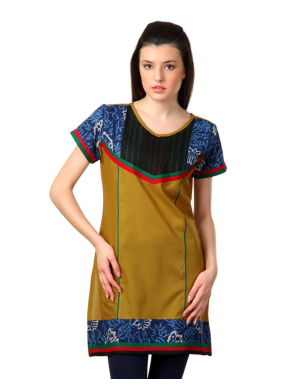

⬇------------------- изображение 40626.jpg -------------------⬇
Style Note


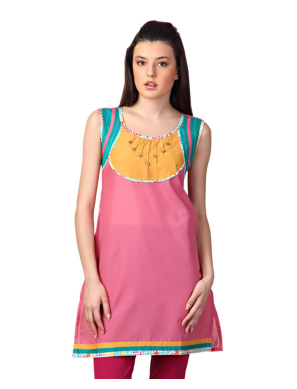

⬇------------------- изображение 40655.jpg -------------------⬇
Style Note


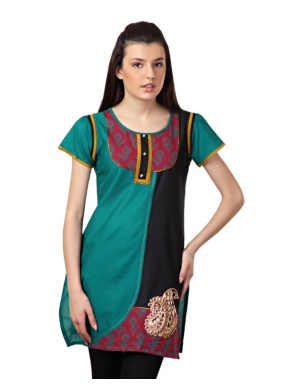

In [16]:
show_images (df [df['description'] == 'Style Note'][:3])

-- такие дубликаты удалим, т. к. описание бессмысленное.

In [17]:
df = df [df['description'] != 'Style Note']

⬇------------------- изображение 55946.jpg -------------------⬇
Chip-resistant and prevents yellowing of nails Fast drying and long wearing
Simple one stroke application


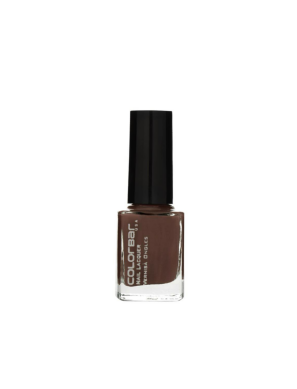

⬇------------------- изображение 55892.jpg -------------------⬇
Chip-resistant and prevents yellowing of nails Fast drying and long wearing
Simple one stroke application


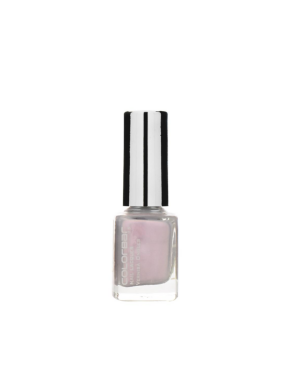

⬇------------------- изображение 55863.jpg -------------------⬇
Chip-resistant and prevents yellowing of nails Fast drying and long wearing
Simple one stroke application


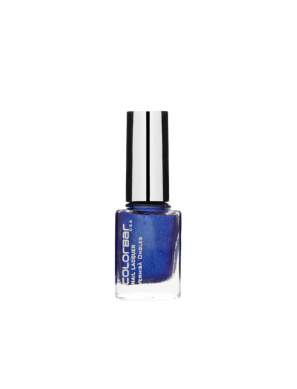

In [18]:
show_images (df [df['description'] == 'Chip-resistant and prevents yellowing of'
                 ' nails Fast drying and long wearing Simple one stroke application'][:3])

-- такие дубликаты оставим.

Посмотрим разрешения картинок:

In [19]:
def get_resolution (row):
    image_path = os.path.join (IMAGES_PATH, row['image'])
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width, height
    except FileNotFoundError:
        print(f"Ошибка: Файл не найден по пути {image_path}")
    except Exception as e:
        print(f"Произошла ошибка при обработке изображения: {e}")    


df [['width', 'height']] = df.apply(get_resolution, axis=1, result_type='expand')

In [20]:
df['width'].value_counts()

width
1080    43107
Name: count, dtype: int64

In [21]:
df['height'].value_counts()

height
1440    43107
Name: count, dtype: int64

Все изображения имеют разрешение  1080х1440

Посмотрим на несколько случайных изображений и текстов, оценим их соответствие:

In [22]:
pd.options.display.max_colwidth = 10

⬇------------------- изображение 16029.jpg -------------------⬇
Composition Blue and white check shirt with red accents, made of 100% cotton,
has full sleeves with buttoned cuffs, spread collar, front buttoned placket,
patch pocket on the left chest with embroidered brand logo above it and a curved
hem Fitting Regular Wash care Machine wash at 40 degrees Wash dark colours
separately Do not bleach Tumble dry normal or line dry Warm iron Crafted from
soft cotton and designed with cuts that offer a flattering silhouette, this
shirt from highlander is sure to become a wardrobe favourite. Pair it with
jeans, throw over a blazer and slip into suede boots or sneakers. Model
statistics The model wears size M in shirts Height: 6', Shoulders: 18"


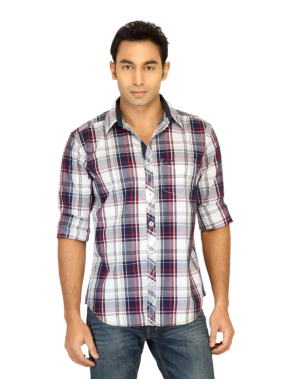

⬇------------------- изображение 46490.jpg -------------------⬇
Case style:nbsp;Analogue watch, has annbsp;oval case and anbsp;stainless steel
back Dial style: White dial Features: A screw to reset time Strap style: Silver
and gold-toned bracelet-style strap with white stones, securednbsp;with
anbsp;fold-over clasp Water-resistant Comes in a signature Timex case Warranty:
1 year against manufacturing defectsnbsp;from the date of purchase Warranty
provided by Brand Owner / Manufacturer


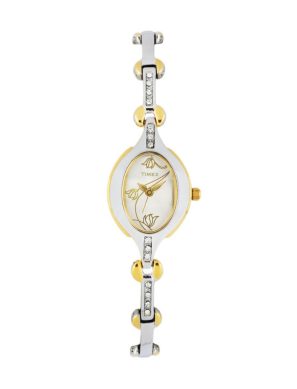

⬇------------------- изображение 1906.jpg -------------------⬇
1. 100% Cotton(180 gsm) 2. Crew Neck half sleeves t-shirt This t-shirt graphic
represents the football used during 1904. It explains the Establishment of fifa
on May 21, 1904. t-shirts or “Tees” as they are called have become an essential
part of our dressing. No one really has remained untouched by the influence of
t-shirts. The comfort, ease of use and variety that a t-shirt offers makes it
the most preferred casual wear. It goes well with jeans, pants, shorts – almost
anything that one can think of. There are t-shirts available in various fits and
sizes for men. While doing your everyday activities, as daily wear or as Friday
dressing to office, there's a none better choice than a t-shirt. T-shirts also
come with terrific designs on it and are available in various colours. Feel
good, feel light and have a great time as your slip into your very own t-shirt.
Model statistics The model wears size M in T-shirts Height-5.11",

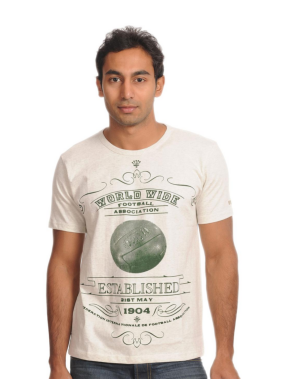

⬇------------------- изображение 54944.jpg -------------------⬇
Blue polo T-shirt, ribbed cutaway collar, two buttoned placket, short sleeves
and embroidered detail on the chest


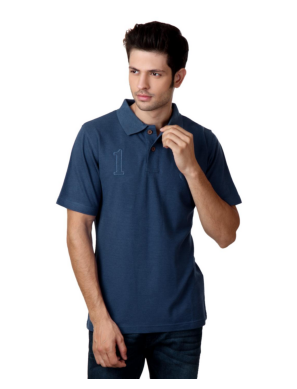

⬇------------------- изображение 40044.jpg -------------------⬇
Style Note  adidas helps you avoid discomfort and keep dry and comfortable. This
T-shirt, engineered with Climacool technology, offers you a flattering stylised
look. Pair it with a pair of jeans and sports shoes on your day off, or with
shorts and Sports shoes when you're hitting the gym.   Product Details  Black
T-shirt, has a round neckline, short sleeves with Adidas patented three stripes
on the arms, branding on the left side of the chest and graphic print on the
chest   Material and Care 100% polyester Machine wash cool with like colours
using a mild detergent Do not soak, tumble dry, bleach or dry clean Dry in shade
Cold iron  do not iron on decorations   Size and Fit Regular fit The model
(height 6' and shoulders 18") is wearing a size M


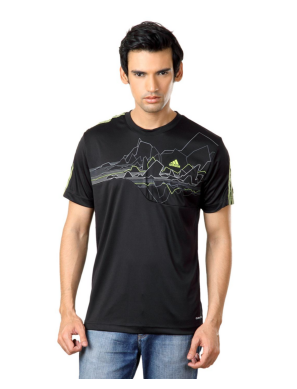

⬇------------------- изображение 3235.jpg -------------------⬇
Composition: Black, blue, white ballerina flats made of patent leather with
rubber outsoles These ballerina flats from puma are both feminine and versatile.
They feature mesh uppers with a patent leather trim, graphic accents and a blue
cushioned footbed. The rubber outsoles bring in extra grip making these shoes
perfect for urban living.


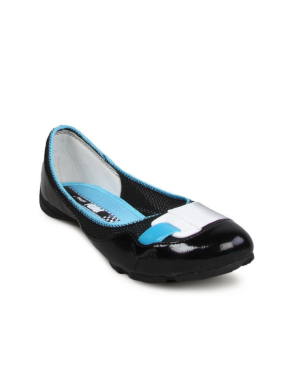

⬇------------------- изображение 35827.jpg -------------------⬇
fila shoes originate from Italy's materials capital Biella, and can be relied on
for quality and optimal durability. This Cavier shoe with its sport shoe styling
and padded inner is sure to become a closet favourite. Style this sockless with
shorts , it's a perfect slip-on when you're in a hurry! Upper Mesh upper with
synthetic overlays Reinforced overlay at the toe box and heel collar Central
lace ups Padded tongue with branding Padded fabric with inner Embossed branding
on the fore foot Midsole Rubber midsole for cushioned comfort Outsole TPU
outsole with a curved midfoot and a decoupled heel Geometric grooves inside
terraced lugs Shoe care Wipe surface with a dry, clean cloth to remove dust Do
not machine wash


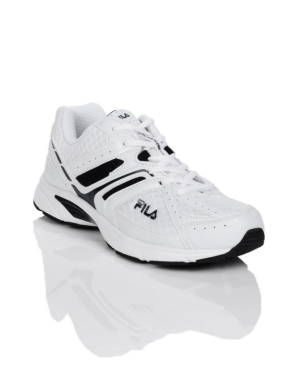

⬇------------------- изображение 15089.jpg -------------------⬇
Composition Red and black checked shirt made of 100% cotton, that has spread
collar, full length sleeves with buttoned cuffs, a full length buttoned placket
with buttons made of wood, an insert pocket on the left chest, and a curved
hemline Fitting Regular Wash care Hand wash separately in cold water using a
mild detergent as colour may bleed Flat dry inside out in shade Warm iron The
classic rage of natural fabrics combined with vintage cuts is back with a
vengeance. Wear this collared shirt from mother earth with washed denims and
chappals. Model statistics The model wears size M in shirts Height-6',
Shoulders-18"


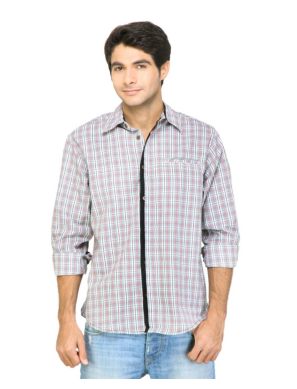

⬇------------------- изображение 6259.jpg -------------------⬇
Composition White round neck sleeveless t-shirt made of PV jersey, with graphic
print all over in anvy and two pockets on the front above the hem Fitting
Comfort Wash care   Hand wash cold  Wash dark colours separately  Use mild
detergent  Do not bleach  Do not wring or tumble dry  Flat dry in shade  Warm
iron  Do not iron on print/embellishments   There's no better way to get casual
than in this absolutely flowey viscose fabric tee from lee. The anvy coloured
print across the entire top adds to the comfort mood, while the two front
pockets above the hem are the best way to relax your hands into. Team this with
shorts or tracks for that absolutely comfortable and casual look. Model
statistics The model wears size M in t-shirts Height-5.7", Chest-33", Waist-26"


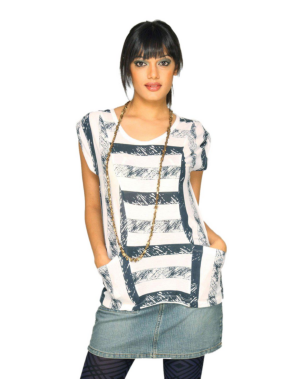

⬇------------------- изображение 19877.jpg -------------------⬇
Colour-happy flip flops for girls from adidas. The printed design on the insole
inspired by op art is sure to appeal to psychedelic sensibilities. Pair them
with a similar toned tee and fitted denims or capris.  Upper Fabric thong straps
with the adidas patented 3-Stripes Fabric toe separator PU footbed with print
for all-day massage feel with printed branding  Outsole TPR outsole with
geometric textured lugs for maximum traction  shoe care Wipe off dirt with a
moist cloth Do not machine wash


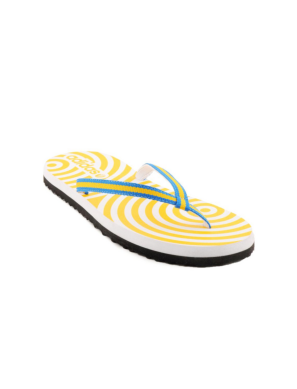

In [23]:
show_images (df.sample(10, random_state=RANDON_STATE))

Описания данных 10 изображений являются корректными.

In [24]:
df.shape

(43107, 4)

## Выводы по итогам EDA



- удалены образцы с пустыми или с незначищими описаниями (без букв)
- все изображения имеют разрешение  1080х1440
- всего изображения в датасете осталось 43107
- описания выборочных 10 изображений являются корректными

## Подготовка датасета

Реализуем свой класс датасета, который будет подгружать картинки и соответствующие им текстовые описания.

разделим данные на трейн и тест (10% от всех данных):

## Загрузка модели

## Дообучение

# Этап 2. Реализация системы поиска товаров

## Подготовка данных

## Функция поиска товаров

## Тестирование

# Выводы

